In [1]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras import regularizers
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
samples = []
#csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv']
csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv', \
            'data/data/data_pat/track1_central/driving_log.csv', 'data/data/data_pat/track1_recovery/driving_log.csv', \
            'data/data/data_pat/track1_recovery_reverse/driving_log.csv', 'data/data/data_pat/track1_reverse/driving_log.csv']
for j in range(7):
    if j==8:
        # 0 = my own data, 1 = Udacity supplied data , any other no = use both dataset
        print('not using dataset ', j)
        continue
    with open(csv_path[j]) as csvfile:
        #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
        reader = csv.reader(csvfile)
        for line in reader:
             # skip it if ~0 speed - not representative of driving behavior
            if float(line[6]) < 0.1 :
                continue
            if (float(line[3])>0.01 and float(line[3])<0.9) or (float(line[3])>-0.9 and float(line[3])<-0.01):
                samples.append(line)
            else:
                select_prob = np.random.random()
                if select_prob > 0.5:
                    samples.append(line)
                
            #samples.append(line)
        
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print (len(samples), len(train_samples), len(validation_samples), samples[550])
a= np.array(samples)

14675 11740 2935 ['IMG/center_2016_12_01_13_33_55_995.jpg', 'IMG/left_2016_12_01_13_33_55_995.jpg', 'IMG/right_2016_12_01_13_33_55_995.jpg', '-0.2116669', '0.9855326', '0', '30.18678']


[-1.         -0.92038732 -0.84077463 -0.76116195 -0.68154926 -0.60193658
 -0.5223239  -0.44271121 -0.36309853 -0.28348584 -0.20387316 -0.12426048
 -0.04464779  0.03496489  0.11457758  0.19419026  0.27380294  0.35341563
  0.43302831  0.512641    0.59225368  0.67186636  0.75147905  0.83109173
  0.91070442  0.9903171 ] [ 195    6   11   20   16   32   80  116  235  519  713 1464 7559 1612 1045
  414  234  149   52   23   18    5    3    1  153    1]


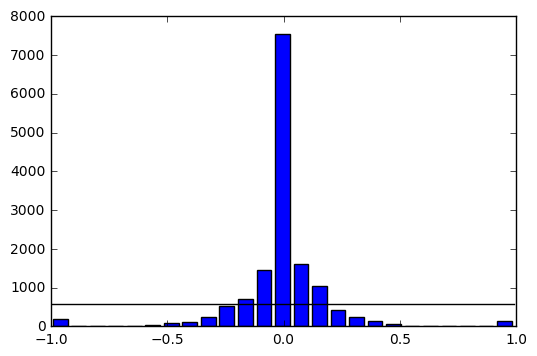

In [3]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [4]:
samples2 = []
steering_angles2 = []

def SubSample(samples, a_angles):
    # determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
    # to number of samples above the average, so as to bring the number of samples for that bin down to the average
    keep_probs2 = []
    target = avg_samples_per_bin
    for i in range(num_bins):
        #print(bins[i])
        if hist[i] < target:
            keep_probs2.append(1.)
        else:
            keep_probs2.append(1./(hist[i]/target))
    for i in range(len(a_angles)):
        for j in range(num_bins):
            if a_angles[i] > bins[j] and a_angles[i] <= bins[j+1]:
                # delete from X and y with probability 1 - keep_probs[j]
                if np.random.rand() < keep_probs2[j] and a_angles[i]>=-0.90 and a_angles[i]<=0.90:
                    samples2.append(samples[i])
                    steering_angles2.append(a_angles[i])

[-0.8749067  -0.80489438 -0.73488205 -0.66486973 -0.5948574  -0.52484508
 -0.45483276 -0.38482043 -0.31480811 -0.24479578 -0.17478346 -0.10477114
 -0.03475881  0.03525351  0.10526584  0.17527816  0.24529048  0.31530281
  0.38531513  0.45532746  0.52533978  0.5953521   0.66536443  0.73537675
  0.80538908  0.8754014 ] [ 10  10  18  19  26  49 116 107 393 417 518 524 563 552 429 500 242 206
  55  41  20  16   3   5   1   1]


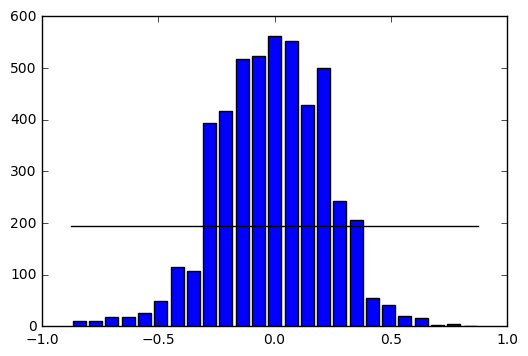

In [5]:

a_angles = a[:,3].astype(np.float)
SubSample(samples, a_angles)
# print a histogram to see which steering angle ranges are most overrepresented
b_angles2 = steering_angles2
num_bins = 25
avg_samples_per_bin = len(steering_angles2)/num_bins
hist, bins = np.histogram(b_angles2, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(b_angles2), np.max(b_angles2)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [6]:
train_samples, validation_samples = train_test_split(samples2, test_size=0.2)
print (len(samples2), len(train_samples), len(validation_samples), samples[550])

4840 3872 968 ['IMG/center_2016_12_01_13_33_55_995.jpg', 'IMG/left_2016_12_01_13_33_55_995.jpg', 'IMG/right_2016_12_01_13_33_55_995.jpg', '-0.2116669', '0.9855326', '0', '30.18678']


In [7]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64, 64))
    
    #image2 = np.zeros(image.shape, dtype='u1')
    #image2 = brightness_process_image(image, image2)
    
    return image

In [8]:
def transform_image(image,ang_range,shear_range,trans_range):
# Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
# Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
# Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    #image2 = np.zeros(X_train[0].shape, dtype='u1')
    # Preprocessing 
    #image2 = brightness_process_image(image,image2)     # brightness Normalization & Augmentaion
    
    return image

(64, 64, 3) (64, 10, 3)


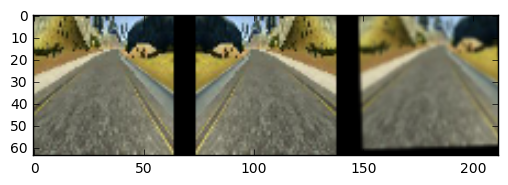

In [9]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

divider = np.asarray(np.zeros((64,10,3), dtype='u1'))

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[250][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape, divider.shape)
img_center1_flipped = np.fliplr(img_center1)
img_center2 = transform_image(img_center1,2,2,2)
res1 = np.hstack((img_center1, divider, img_center1_flipped, divider, img_center2))
plt.imshow(res1)


In [10]:
def Augmentation(row, car_images, steering_angles):
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.17     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    img_center = process_image(np.asarray(Image.open(path+row[0])))
    img_center_flipped = np.fliplr(img_center)
    img_left = process_image(np.asarray(Image.open(path+row[1])))
    img_left_flipped = np.fliplr(img_left)
    img_right = process_image(np.asarray(Image.open(path + row[2])))
    img_right_flipped = np.fliplr(img_right)
    
    # add images and angles to data set
    car_images.append(img_center)
    car_images.append(img_center_flipped)
    car_images.append(img_left)
    car_images.append(img_left_flipped)
    car_images.append(img_right)
    car_images.append(img_right_flipped)
    steering_angles.append(steering_center)
    steering_angles.append(-steering_center)
    steering_angles.append(steering_left)
    steering_angles.append(-steering_left)
    steering_angles.append(steering_right)
    steering_angles.append(-steering_right)
    
    camera = np.random.choice(['center', 'left', 'right'], p=[0.3,0.35,0.35])
    if camera == "center" :    
        car_images.append(transform_image(img_center,2,2,2))
        steering_angles.append(steering_center)
        car_images.append(transform_image(img_center_flipped,2,2,2))
        steering_angles.append(-steering_center)
    if camera == "left" :    
        car_images.append(transform_image(img_left,2,2,2))
        steering_angles.append(steering_left)
        car_images.append(transform_image(img_right_flipped,2,2,2))
        steering_angles.append(-steering_right)
    if camera == "right" :    
        car_images.append(transform_image(img_right,2,2,2))
        steering_angles.append(steering_right)
        car_images.append(transform_image(img_left_flipped,2,2,2))
        steering_angles.append(-steering_left)

In [11]:
def Augmentation_None(row, car_images, steering_angles):
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.12     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    img_center = process_image(np.asarray(Image.open(path+row[0])))
    img_center_flipped = np.fliplr(img_center)
    img_left = process_image(np.asarray(Image.open(path+row[1])))
    img_left_flipped = np.fliplr(img_left)
    img_right = process_image(np.asarray(Image.open(path + row[2])))
    img_right_flipped = np.fliplr(img_right)
    
    # add images and angles to data set
    car_images.append(img_center)
    car_images.append(img_center_flipped)
    car_images.append(img_left)
    car_images.append(img_left_flipped)
    car_images.append(img_right)
    car_images.append(img_right_flipped)
    steering_angles.append(steering_center)
    steering_angles.append(-steering_center)
    steering_angles.append(steering_left)
    steering_angles.append(-steering_left)
    steering_angles.append(steering_right)
    steering_angles.append(-steering_right)

In [12]:
def generator(samples, augment=True, batch_size=256):
    num_samples = int(len(samples)/2.7)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []

            for row in batch_samples:
                if augment==True:
                    Augmentation(row, car_images, steering_angles)
                else:
                    Augmentation(row, car_images, steering_angles)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [13]:
# compile and train the model using the generator function
train_generator = generator(train_samples, augment=True, batch_size=256)
validation_generator = generator(validation_samples, augment=False, batch_size=256)

In [ ]:
model = Sequential()
# Normalize
#model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
#model.add(Convolution2D(3,1,1,border_mode='valid', name='conv0'))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(16, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 13x13x16
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 5
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 16)    1216        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 32, 32, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 15, 15, 32)    4640        elu_1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model.compile(loss='mse', optimizer=Adam(lr=1e-4))
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*2, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*2, nb_epoch=15, verbose=1)          #https://keras.io/models/sequential/#fit_generator

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_test.h5')

Epoch 1/15
6144/7744 [======================>.......] - ETA: 1s - loss: 0.1271

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8192/7744 [===============================] - 9s - loss: 0.1185 - val_loss: 0.0503
Epoch 2/15
8192/7744 [===============================] - 5s - loss: 0.0848 - val_loss: 0.0365
Epoch 3/15
8192/7744 [===============================] - 6s - loss: 0.0703 - val_loss: 0.0378
Epoch 4/15
8192/7744 [===============================] - 5s - loss: 0.0587 - val_loss: 0.0371
Epoch 5/15
8192/7744 [===============================] - 5s - loss: 0.0531 - val_loss: 0.0389
Epoch 6/15
8192/7744 [===============================] - 5s - loss: 0.0507 - val_loss: 0.0343
Epoch 7/15
8192/7744 [===============================] - 5s - loss: 0.0476 - val_loss: 0.0317
Epoch 8/15
6144/7744 [======================>.......] - ETA: 0s - loss: 0.0436